# Dive into Deep Learning (DDL): Ch. 5.1-5.2, 5.3-5.5. 

Work through Section 5.2.4, Exercises 1-4.

In [ ]:
#5.1 Notes
#multilayer perceptron: stack many fully connected layers on top of one another. one or more hidden layers. 
# Each layer (representation) feeds into the layer above it, until we generate outputs in the final layer (linear predictor).
#For nonlinearity, to avoid collapsing into single layer model, apply a nonlinear activation function (ReLU) to each hidden unit following the affine transformation.
# Output of activation functions are called activations
#ReLU(x) = max(x, 0)
#sigmoid function transforms inputs in range (-inf, inf) to outputs in (0, 1), so its a squashing function.

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#Using classification dataset with 784 input features and 10 classes
#implement an MLP with one hidden layer and 256 hidden units

class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma) #for every layer, we must keep track of one weight matrix and one bias vector using nn.Parameter
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

In [3]:
def relu(X): #activation
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [5]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs)) #reshape each two-dimensional image into a flat vector of length num_inputs
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

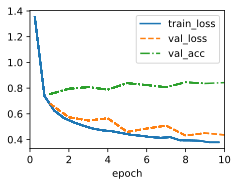

In [6]:
#training loop: define the model, data, and trainer, then finally invoke the fit method on model and data

model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [7]:
#Using higher level APIs to implement MLP:

class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs)) #two fully connected layers

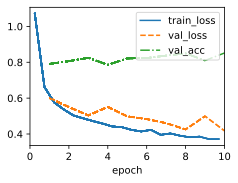

In [8]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

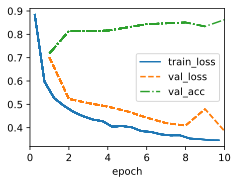

In [9]:
#5.2.4.1 Changing the number of hidden units to num_hiddens=4096 and plotting how its number affects the accuracy of the model:
model = MLP(num_outputs=10, num_hiddens=4096, lr=0.1)
trainer.fit(model, data)

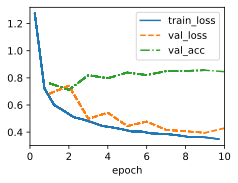

In [11]:
#5.2.4.2: Adding a hidden layer
class AnotherHiddenLayerMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                nn.ReLU(), nn.LazyLinear(num_hiddens), #new hidden layer
                                nn.ReLU(), nn.LazyLinear(num_outputs))
model = AnotherHiddenLayerMLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

In [12]:
#5.2.4.3: Adding a hidden layer with a single neuron is a bad idea since it is a bottleneck that doesn't offer any useful representation of the underlying patterns in the data

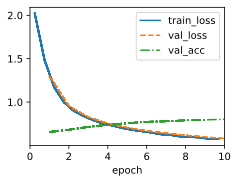

In [13]:
#5.2.4.4: Changing the learning rate to lr=0.01 from 0.1 
model = MLP(num_outputs=10, num_hiddens=256, lr=0.01)
trainer.fit(model, data)
#This relates to the number of epochs since the training results keep getting better, while the validation accuracy and loss improve initially and then get worse. 

# Dive into Deep Learning (DDL): Ch. 5.6-5.7. 

Work through Section 5.7.10, Exercises 1-3

In [14]:
# Chapter 5.6 Notes:
#Dropout randomly "drops out" a certain percentage of neurons in each layer, forces the network to become more robust and prevents it from relying too heavily on specific neurons, 
#standard dropout regularization: Ensures E[x']=x for input x, formula is h' = 0 with probability p and h/(1-p) otherwise.
#Dropout, as well as controlling the number of dimensions and the size of the weight vector, are all useful for avoiding overfitting

In [55]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [56]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [57]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape) #training dataset includes 1460 examples, 80 features, and one label (SalePrice)
print(data.raw_val.shape) #validation data contains 1459 examples and 80 features

(1460, 81)
(1459, 80)


In [58]:
data.raw_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [59]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std())) #zero mean and unit variance
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [60]:
data.preprocess()
data.train.shape #increases the number of features from 79 to 331

(1460, 331)

In [62]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [63]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx), # slicing the ith segment as validation data and returning the rest as training data
                                data.train.loc[idx]))
    return rets

In [64]:
#average validation error is returned when we train k times in the k-fold cross-validation
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

/Users/kushagraghosh/opt/anaconda3/envs/bassconnections/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/kushagraghosh/opt/anaconda3/envs/bassconnections/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/kushagraghosh/opt/anaconda3/envs/bassconnections/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/kushagraghosh/opt/anaconda3/en

average validation log mse = 0.17827904492616653


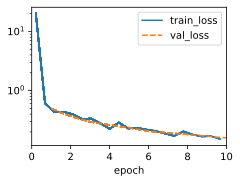

In [65]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

In [66]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})

In [73]:
print(len(preds), preds[0].shape)


5 torch.Size([1459, 1])


/Users/kushagraghosh/opt/anaconda3/envs/bassconnections/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/kushagraghosh/opt/anaconda3/envs/bassconnections/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/kushagraghosh/opt/anaconda3/envs/bassconnections/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


average validation log mse = 0.15389388613402843


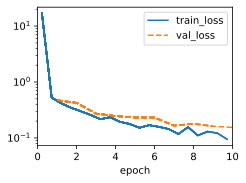

In [76]:
#5.7.10.2: It isn't always a good idea to replace missing values by a mean because certain values might be missing due to the nature of the value itself (for example, people may not report certain information that would be harmful for them if released to the general public)

#5.7.10.3: Improving the score by tuning the hyperparameters through k-fold cross-validation: 
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=4, lr=0.02)